In [1]:
import os


In [2]:
from __future__ import print_function
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.datasets import mnist
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
import cv2

Using TensorFlow backend.
C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ASUS\Anaconda3

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
Vld_Splt= 0.0909
batch_size = 200
num_classes = 10
epochs = 30

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)\
         .astype('float32')
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1).\
         astype('float32')
x_train /= 255
x_test /= 255
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [6]:
print(y_train.shape, '\n',y_test.shape,'\n',
      x_train.shape,'\n', x_test.shape)

(60000, 10) 
 (10000, 10) 
 (60000, 28, 28, 1) 
 (10000, 28, 28, 1)


In [7]:
# the squashing function.
# we use 0.5 in stead of 1 in hinton's paper.
# if 1, the norm of vector will be zoomed out.
# if 0.5, the norm will be zoomed in while original norm is less than 0.5
# and be zoomed out while original norm is greater than 0.5.
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x


# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)


# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)


class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [8]:
"""one-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_0 = Conv2D(filters= 300, kernel_size= 5, activation='relu', 
             padding= 'valid')(input_image)
x_0= Dropout(0.1)(x_0)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_0 = Reshape((-1, 300))(x_0)
capsule_0 = Capsule(num_classes, 16, 3, True)(x_0)
output_0 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_0)
model_0 = Model(inputs= input_image, outputs= output_0)

# we use a margin loss
model_0.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_0.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 300)       7800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 300)       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 576, 300)          0         
_________________________________________________________________
capsule_1 (Capsule)          (None, 10, 16)            48000     
_________________________________________________________________
lambda_1 (Lambda)            (None, 10)                0         
Total params: 55,800
T

In [9]:
"""two-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_1 = Conv2D(filters= 30, kernel_size= 5, activation='relu', 
             padding= 'valid')(input_image)
x_1= Dropout(0.1)(x_1)
x_1 = Conv2D(filters= 60, kernel_size= 5, activation='relu',
             strides= 1)(x_1)
x_1 = Dropout(0.1)(x_1)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_1 = Reshape((-1, 60))(x_1)
capsule_1 = Capsule(num_classes, 16, 3, True)(x_1)
output_1 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_1)
model_1= Model(inputs= input_image, outputs= output_1)

# we use a margin loss
model_1.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_1.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 30)        780       
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 30)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 60)        45060     
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 20, 60)        0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 400, 60)           0         
_________________________________________________________________
capsule_2 (Capsule)          (None, 10, 16)            9600      
__________

In [10]:
"""three-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_2 = Conv2D(filters= 25, kernel_size= 5, activation='relu', 
             padding= 'valid')(input_image)
x_2= Dropout(0.1)(x_2)
x_2 = Conv2D(filters= 25, kernel_size= 5, activation='relu',
             strides= 1)(x_2)
x_2 = Dropout(0.1)(x_2)
x_2 = Conv2D(filters= 45, kernel_size= 5, activation='relu',
             strides= 1)(x_2)
x_2 = Dropout(0.1)(x_2)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_2 = Reshape((-1, 45))(x_2)
capsule_2 = Capsule(num_classes, 16, 3, True)(x_2)
output_2 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_2)
model_2= Model(inputs= input_image, outputs= output_2)

# we use a margin loss
model_2.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_2.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 25)        650       
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24, 25)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 25)        15650     
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 20, 25)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 45)        28170     
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 45)        0         
__________

In [11]:
"""four-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_3 = Conv2D(filters= 15, kernel_size= 5, activation='relu', 
             padding= 'valid')(input_image)
x_3= Dropout(0.1)(x_3)
x_3 = Conv2D(filters= 25 ,kernel_size= 5, activation='relu',
             strides= 1)(x_3)
x_3 = Dropout(0.1)(x_3)
x_3 = Conv2D(filters= 25, kernel_size= 5, activation='relu',
             strides= 1)(x_3)
x_3= Dropout(0.1)(x_3)
x_3 = Conv2D(filters= 35,kernel_size= 5, activation='relu',
             strides= 1)(x_3)
x_3= Dropout(0.1)(x_3)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_3 = Reshape((-1, 35))(x_3)
capsule_3 = Capsule(num_classes, 16, 3, True)(x_3)
output_3 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_3)
model_3= Model(inputs= input_image, outputs= output_3)

# we use a margin loss
model_3.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_3.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 15)        390       
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 24, 15)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 25)        9400      
_________________________________________________________________
dropout_8 (Dropout)          (None, 20, 20, 25)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 25)        15650     
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 25)        0         
__________

In [12]:
"""five-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_4 = Conv2D(filters= 15, kernel_size= 5, activation='relu', 
             padding= 'valid')(input_image)
x_4= Dropout(0.1)(x_4)
x_4 = Conv2D(filters= 20 ,kernel_size= 5, activation='relu',
             strides= 1)(x_4)
x_4 = Dropout(0.1)(x_4)
x_4 = Conv2D(filters= 20, kernel_size= 5, activation='relu',
             strides= 1)(x_4)
x_4= Dropout(0.1)(x_4)
x_4 = Conv2D(filters= 25,kernel_size= 5, activation='relu',
             strides= 1)(x_4)
x_4= Dropout(0.1)(x_4)
x_4 = Conv2D(filters= 30,kernel_size= 5, activation='relu',
             strides= 1)(x_4)
x_4= Dropout(0.1)(x_4)

"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_4 = Reshape((-1, 30))(x_4)
capsule_4 = Capsule(num_classes, 16, 3, True)(x_4)
output_4 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_4)
model_4= Model(inputs= input_image, outputs= output_4)

# we use a margin loss
model_4.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_4.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 15)        390       
_________________________________________________________________
dropout_11 (Dropout)         (None, 24, 24, 15)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 20, 20, 20)        7520      
_________________________________________________________________
dropout_12 (Dropout)         (None, 20, 20, 20)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 20)        10020     
_________________________________________________________________
dropout_13 (Dropout)         (None, 16, 16, 20)        0         
__________

In [13]:
"""six-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_5 = Conv2D(filters= 15, kernel_size= 5, activation='relu', 
             padding= 'same')(input_image)
x_5= Dropout(0.1)(x_5)
x_5 = Conv2D(filters= 15 ,kernel_size= 5, activation='relu',
             strides= 2)(x_5)
x_5 = Dropout(0.1)(x_5)
x_5 = Conv2D(filters= 15, kernel_size= 5, activation='relu',
             strides= 1)(x_5)
x_5= Dropout(0.1)(x_5)
x_5 = Conv2D(filters= 20,kernel_size= 5, activation='relu',
             padding= 'same')(x_5)
x_5= Dropout(0.1)(x_5)
x_5 = Conv2D(filters= 25,kernel_size= 5, activation='relu',
             padding= 'same')(x_5)
x_5= Dropout(0.1)(x_5)
x_5 = Conv2D(filters= 25,kernel_size= 5, activation='relu',
             strides= 1)(x_5)
x_5= Dropout(0.1)(x_5)

"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_5 = Reshape((-1, 25))(x_5)
capsule_5 = Capsule(num_classes, 16, 3, True)(x_5)
output_5 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_5)
model_5= Model(inputs= input_image, outputs= output_5)

# we use a margin loss
model_5.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_5.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 15)        390       
_________________________________________________________________
dropout_16 (Dropout)         (None, 28, 28, 15)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 12, 12, 15)        5640      
_________________________________________________________________
dropout_17 (Dropout)         (None, 12, 12, 15)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 15)          5640      
_________________________________________________________________
dropout_18 (Dropout)         (None, 8, 8, 15)          0         
__________

In [14]:
"""seven-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_6 = Conv2D(filters= 15, kernel_size= 5, activation='relu', 
             padding= 'valid')(input_image)
x_6= Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 15 ,kernel_size= 5, activation='relu',
             padding= 'same')(x_6)
x_6 = Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 15, kernel_size= 5, activation='relu',
             strides= 1)(x_6)
x_6= Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 15,kernel_size= 5, activation='relu',
             padding= 'same')(x_6)
x_6= Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 20,kernel_size= 5, activation='relu',
             strides= 2)(x_6)
x_6= Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 25,kernel_size= 5, activation='relu',
             padding= 'same')(x_6)
x_6= Dropout(0.1)(x_6)
x_6 = Conv2D(filters= 25,kernel_size= 5, activation='relu',
             strides= 1)(x_6)
x_6= Dropout(0.1)(x_6)

"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_6 = Reshape((-1, 25))(x_6)
capsule_6 = Capsule(num_classes, 16, 3, True)(x_6)
output_6 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_6)
model_6= Model(inputs= input_image, outputs= output_6)

# we use a margin loss
model_6.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_6.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 24, 24, 15)        390       
_________________________________________________________________
dropout_22 (Dropout)         (None, 24, 24, 15)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 24, 24, 15)        5640      
_________________________________________________________________
dropout_23 (Dropout)         (None, 24, 24, 15)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 20, 20, 15)        5640      
_________________________________________________________________
dropout_24 (Dropout)         (None, 20, 20, 15)        0         
__________

In [15]:
"""CNN-3-CONV-LAYERS"""
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, \
                         ZeroPadding2D

model_7= Sequential()
model_7.add(Conv2D(filters= 5, kernel_size= (5, 5), padding= 'same', 
                   input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), 
                   activation='relu'))
model_7.add(MaxPooling2D(pool_size=(2,2)))
model_7.add(Conv2D(filters= 20, kernel_size= (5, 5), 
                    padding= 'valid', activation='relu'))
model_7.add(Dropout(0.3))
model_7.add(MaxPooling2D(pool_size=(2,2)))

model_7.add(Flatten())
model_7.add(Dropout(0.4))
model_7.add(Dense(256, activation='relu'))
model_7.add(Dense(num_classes, activation='softmax'))
print(model_7.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 28, 28, 5)         130       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 5)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 10, 10, 20)        2520      
_________________________________________________________________
dropout_29 (Dropout)         (None, 10, 10, 20)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 500)               0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 500)               0         
_________

In [16]:
"""one-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_0= model_0.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_0= model_0.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 19s 356us/step - loss: 0.3342 - acc: 0.6820 - val_loss: 0.1801 - val_acc: 0.9032
Epoch 2/30
54546/54546 [==============================] - 17s 319us/step - loss: 0.1632 - acc: 0.8911 - val_loss: 0.1345 - val_acc: 0.9201
Epoch 3/30
54546/54546 [==============================] - 17s 320us/step - loss: 0.1397 - acc: 0.9079 - val_loss: 0.1167 - val_acc: 0.9323
Epoch 4/30
54546/54546 [==============================] - 17s 321us/step - loss: 0.1282 - acc: 0.9163 - val_loss: 0.1199 - val_acc: 0.9327
Epoch 5/30
54546/54546 [==============================] - 18s 322us/step - loss: 0.1197 - acc: 0.9232 - val_loss: 0.1050 - val_acc: 0.9389
Epoch 6/30
54546/54546 [==============================] - 17s 321us/step - loss: 0.1131 - acc: 0.9283 - val_loss: 0.1004 - val_acc: 

In [17]:
"""two-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_1= model_1.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_1= model_1.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 10s 188us/step - loss: 0.3314 - acc: 0.6849 - val_loss: 0.1502 - val_acc: 0.9298
Epoch 2/30
54546/54546 [==============================] - 10s 180us/step - loss: 0.1324 - acc: 0.9216 - val_loss: 0.0957 - val_acc: 0.9534
Epoch 3/30
54546/54546 [==============================] - 10s 182us/step - loss: 0.0959 - acc: 0.9440 - val_loss: 0.0745 - val_acc: 0.9642
Epoch 4/30
54546/54546 [==============================] - 10s 179us/step - loss: 0.0765 - acc: 0.9570 - val_loss: 0.0573 - val_acc: 0.9703
Epoch 5/30
54546/54546 [==============================] - 10s 181us/step - loss: 0.0660 - acc: 0.9632 - val_loss: 0.0499 - val_acc: 0.9729
Epoch 6/30
54546/54546 [==============================] - 10s 177us/step - loss: 0.0592 - acc: 0.9668 - val_loss: 0.0439 - val_acc: 0.9771
Epoch 7/30
54546/54546 [==============================] - 10s 181us/step - loss: 0.0539 

In [18]:
"""three-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_2= model_2.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_2= model_2.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 9s 161us/step - loss: 0.3057 - acc: 0.6819 - val_loss: 0.1112 - val_acc: 0.9516
Epoch 2/30
54546/54546 [==============================] - 8s 143us/step - loss: 0.0832 - acc: 0.9519 - val_loss: 0.0496 - val_acc: 0.9732
Epoch 3/30
54546/54546 [==============================] - 8s 143us/step - loss: 0.0514 - acc: 0.9696 - val_loss: 0.0343 - val_acc: 0.9784
Epoch 4/30
54546/54546 [==============================] - 8s 145us/step - loss: 0.0400 - acc: 0.9763 - val_loss: 0.0277 - val_acc: 0.9837
Epoch 5/30
54546/54546 [==============================] - 8s 151us/step - loss: 0.0334 - acc: 0.9802 - val_loss: 0.0237 - val_acc: 0.9870
Epoch 6/30
54546/54546 [==============================] - 8s 152us/step - loss: 0.0292 - acc: 0.9830 - val_loss: 0.0221 - val_acc: 0.9873
Epoch 7/30
54546/54546 [==============================] - 8s 148us/step - loss: 0.0258 - acc: 

In [19]:
"""four-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_3= model_3.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_3= model_3.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 8s 150us/step - loss: 0.2776 - acc: 0.7064 - val_loss: 0.0813 - val_acc: 0.9560
Epoch 2/30
54546/54546 [==============================] - 7s 131us/step - loss: 0.0608 - acc: 0.9599 - val_loss: 0.0337 - val_acc: 0.9758
Epoch 3/30
54546/54546 [==============================] - 7s 128us/step - loss: 0.0365 - acc: 0.9735 - val_loss: 0.0219 - val_acc: 0.9831
Epoch 4/30
54546/54546 [==============================] - 8s 139us/step - loss: 0.0276 - acc: 0.9793 - val_loss: 0.0179 - val_acc: 0.9850
Epoch 5/30
54546/54546 [==============================] - 7s 134us/step - loss: 0.0225 - acc: 0.9835 - val_loss: 0.0157 - val_acc: 0.9855
Epoch 6/30
54546/54546 [==============================] - 7s 134us/step - loss: 0.0194 - acc: 0.9856 - val_loss: 0.0160 - val_acc: 0.9879
Epoch 7/30
54546/54546 [==============================] - 7s 128us/step - loss: 0.0172 - acc: 

In [20]:
"""five-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_4= model_4.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_4= model_4.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 7s 122us/step - loss: 0.1873 - acc: 0.8164 - val_loss: 0.0318 - val_acc: 0.9734
Epoch 2/30
54546/54546 [==============================] - 6s 103us/step - loss: 0.0303 - acc: 0.9748 - val_loss: 0.0192 - val_acc: 0.9811
Epoch 3/30
54546/54546 [==============================] - 6s 105us/step - loss: 0.0200 - acc: 0.9827 - val_loss: 0.0141 - val_acc: 0.9870
Epoch 4/30
54546/54546 [==============================] - 6s 105us/step - loss: 0.0163 - acc: 0.9856 - val_loss: 0.0108 - val_acc: 0.9899
Epoch 5/30
54546/54546 [==============================] - 6s 105us/step - loss: 0.0131 - acc: 0.9886 - val_loss: 0.0100 - val_acc: 0.9895
Epoch 6/30
54546/54546 [==============================] - 6s 102us/step - loss: 0.0119 - acc: 0.9895 - val_loss: 0.0083 - val_acc: 0.9921
Epoch 7/30
54546/54546 [==============================] - 6s 104us/step - loss: 0.0103 - acc: 

In [21]:
"""six-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_5= model_5.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_5= model_5.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 6s 102us/step - loss: 0.2119 - acc: 0.7295 - val_loss: 0.0256 - val_acc: 0.9754
Epoch 2/30
54546/54546 [==============================] - 4s 82us/step - loss: 0.0277 - acc: 0.9714 - val_loss: 0.0137 - val_acc: 0.9840
Epoch 3/30
54546/54546 [==============================] - 5s 84us/step - loss: 0.0182 - acc: 0.9801 - val_loss: 0.0120 - val_acc: 0.9861
Epoch 4/30
54546/54546 [==============================] - 5s 90us/step - loss: 0.0139 - acc: 0.9846 - val_loss: 0.0097 - val_acc: 0.9881
Epoch 5/30
54546/54546 [==============================] - 5s 93us/step - loss: 0.0124 - acc: 0.9862 - val_loss: 0.0077 - val_acc: 0.9908
Epoch 6/30
54546/54546 [==============================] - 6s 102us/step - loss: 0.0110 - acc: 0.9878 - val_loss: 0.0072 - val_acc: 0.9919
Epoch 7/30
54546/54546 [==============================] - 5s 93us/step - loss: 0.0093 - acc: 0.989

In [22]:
"""seven-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_6= model_6.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_6= model_6.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 7s 134us/step - loss: 0.1676 - acc: 0.8137 - val_loss: 0.0211 - val_acc: 0.9793
Epoch 2/30
54546/54546 [==============================] - 6s 115us/step - loss: 0.0243 - acc: 0.9764 - val_loss: 0.0114 - val_acc: 0.9870
Epoch 3/30
54546/54546 [==============================] - 6s 113us/step - loss: 0.0168 - acc: 0.9831 - val_loss: 0.0095 - val_acc: 0.9899
Epoch 4/30
54546/54546 [==============================] - 6s 113us/step - loss: 0.0132 - acc: 0.9861 - val_loss: 0.0084 - val_acc: 0.9903
Epoch 5/30
54546/54546 [==============================] - 6s 117us/step - loss: 0.0118 - acc: 0.9878 - val_loss: 0.0093 - val_acc: 0.9905
Epoch 6/30
54546/54546 [==============================] - 6s 113us/step - loss: 0.0100 - acc: 0.9898 - val_loss: 0.0073 - val_acc: 0.9917
Epoch 7/30
54546/54546 [==============================] - 6s 116us/step - loss: 0.0093 - acc: 

In [23]:
"""CNN-3-CONV-LAYERS"""
model_7.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
train_history_7= model_7.fit(x= x_train, y= y_train, validation_split= Vld_Splt,
                         epochs= epochs, batch_size= batch_size, verbose=1)

Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 4s 67us/step - loss: 0.4052 - acc: 0.8753 - val_loss: 0.0964 - val_acc: 0.9747
Epoch 2/30
54546/54546 [==============================] - 2s 40us/step - loss: 0.1307 - acc: 0.9589 - val_loss: 0.0656 - val_acc: 0.9818
Epoch 3/30
54546/54546 [==============================] - 2s 40us/step - loss: 0.1009 - acc: 0.9682 - val_loss: 0.0563 - val_acc: 0.9831
Epoch 4/30
54546/54546 [==============================] - 2s 40us/step - loss: 0.0840 - acc: 0.9738 - val_loss: 0.0411 - val_acc: 0.9884
Epoch 5/30
54546/54546 [==============================] - 2s 41us/step - loss: 0.0721 - acc: 0.9768 - val_loss: 0.0400 - val_acc: 0.9903
Epoch 6/30
54546/54546 [==============================] - 2s 40us/step - loss: 0.0638 - acc: 0.9796 - val_loss: 0.0374 - val_acc: 0.9894
Epoch 7/30
54546/54546 [==============================] - 2s 42us/step - loss: 0.0571 - acc: 0.9822 - val_loss: 0.0361 - val_acc:

In [24]:
"""one-CONV-LAYERS-THICK"""
scores_0= model_0.evaluate(x_test, y_test)
scores_0[1]

10000/10000 [==============================] - 1s 134us/step


0.9658

In [25]:
"""two-CONV-LAYERS-THICK"""
scores_1= model_1.evaluate(x_test, y_test)
scores_1[1]

10000/10000 [==============================] - 1s 96us/step


0.9873

In [26]:
"""three-CONV-LAYERS-THICK"""
scores_2= model_2.evaluate(x_test, y_test)
scores_2[1]

10000/10000 [==============================] - 1s 94us/step


0.9925

In [27]:
"""four-CONV-LAYERS-THICK"""
scores_3= model_3.evaluate(x_test, y_test)
scores_3[1]

10000/10000 [==============================] - 1s 95us/step


0.9932

In [28]:
"""five-CONV-LAYERS-THICK"""
scores_4= model_4.evaluate(x_test, y_test)
scores_4[1]

10000/10000 [==============================] - 1s 112us/step


0.9924

In [29]:
"""six-CONV-LAYERS-THICK"""
scores_5= model_5.evaluate(x_test, y_test)
scores_5[1]

10000/10000 [==============================] - 1s 115us/step


0.9939

In [30]:
"""seven-CONV-LAYERS-THICK"""
scores_6= model_6.evaluate(x_test, y_test)
scores_6[1]

10000/10000 [==============================] - 1s 112us/step


0.9943

In [31]:
"""CNN"""
scores_7= model_7.evaluate(x_test, y_test)
scores_7[1]

10000/10000 [==============================] - 1s 80us/step


0.9934

In [32]:
import matplotlib.pyplot as plt
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

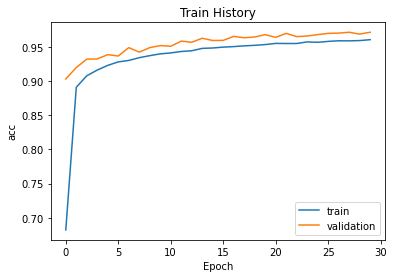

In [33]:
show_train_history(train_history_0, 'acc', 'val_acc')

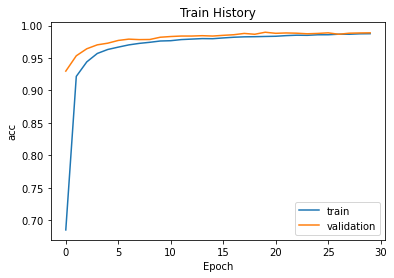

In [34]:
show_train_history(train_history_1, 'acc', 'val_acc')

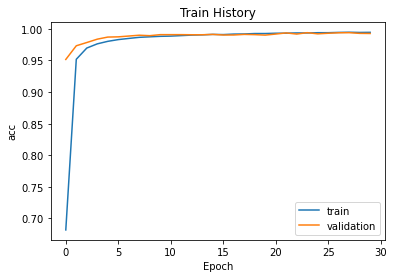

In [35]:
show_train_history(train_history_2, 'acc', 'val_acc')

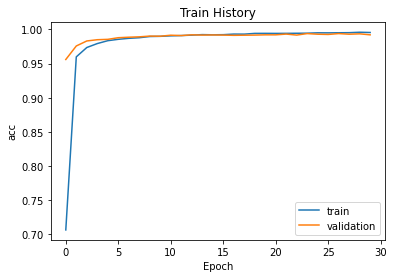

In [36]:
show_train_history(train_history_3, 'acc', 'val_acc')

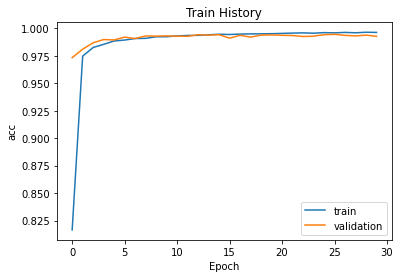

In [37]:
show_train_history(train_history_4, 'acc', 'val_acc')

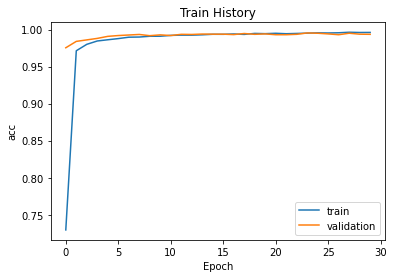

In [38]:
show_train_history(train_history_5, 'acc', 'val_acc')

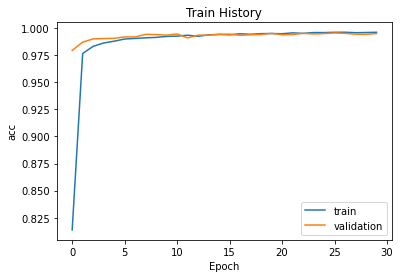

In [39]:
show_train_history(train_history_6, 'acc', 'val_acc')

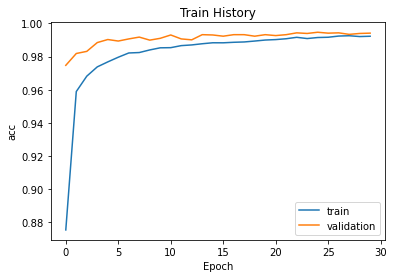

In [40]:
show_train_history(train_history_7, 'acc', 'val_acc')

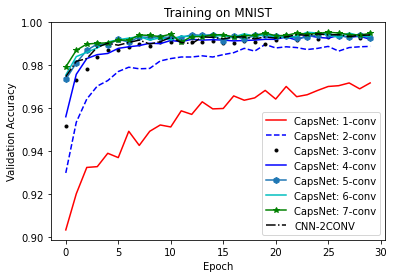

In [41]:
plt.plot(train_history_0.history['val_acc'], 'r-')
plt.plot(train_history_1.history['val_acc'], 'b--')
plt.plot(train_history_2.history['val_acc'], 'k.')
plt.plot(train_history_3.history['val_acc'], 'b-')
plt.plot(train_history_4.history['val_acc'], 'h-')
plt.plot(train_history_5.history['val_acc'], 'c-')
plt.plot(train_history_6.history['val_acc'], 'g*-')
plt.plot(train_history_7.history['val_acc'], 'k-.')
plt.title('Training on MNIST')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['CapsNet: 1-conv','CapsNet: 2-conv','CapsNet: 3-conv','CapsNet: 4-conv','CapsNet: 5-conv','CapsNet: 6-conv',
           'CapsNet: 7-conv','CNN-2CONV'], loc='best')
plt.show()